# Modeling
Build, train and tune ML models to predict heart disease using preprocessed data

In [99]:
# Load Libaries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTENC

# Load the saved data splits
with open("../data/split_data/x_train.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("../data/split_data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("../data/split_data/x_test.pkl", "rb") as f:
    x_test = pickle.load(f)

with open("../data/split_data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

---
## Dealing with Class Imbalance

Note that the dataset is imbalanced, where most entries belong to the "0" class for heart disease status. It is important to deal with this imbalance as it may cause the model to be bias and predict the majority class more. Oversampling to balance the classes in the training set will allow the model to better learn patterns associated with the minority class.

SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method that generates samples for the minority class by interpolating between existing minority class samples. This helps the model better learn patterns and improve predictive performance.

However, SMOTE assumes all features are numeric and this dataset has categorical variables. Interpolation will create fractional values that don't represent valid categories and cause "missing" or invalid values.

SMOTENC (SMOTE for Nominal and Continuous) is used instead, a version of SMOTE that can handle datasets with both numerical and categorical features. SMOTENC treats the categorical variables as discrete and interpolation won't be done on those features, and instead samples will be generated through their categorical nature.

In [75]:
categorical_features = ["exercise_habits", "smoking", "family_heart_disease", "diabetes", "high_blood_pressure", "low_hdl_cholesterol", "high_ldl_cholesterol", "stress_level", "sugar_consumption", "gender_male"]

# Get indices of categorical columns
categorical_indices = []
for col in categorical_features:
    idx = x_train.columns.get_loc(col)
    categorical_indices.append(idx)

# Use SMOTENC with categorical feature indices
smotenc = SMOTENC(categorical_features = categorical_indices, random_state = 1)
x_train_balanced, y_train_balanced = smotenc.fit_resample(x_train, y_train)

print("Balanced training set distribution (SMOTE):")
print(y_train_balanced.value_counts())

Balanced training set distribution (SMOTE):
heart_disease_status
0    6400
1    6400
Name: count, dtype: int64


---
## Training and Comparing Models
A variety of modeling strategies will be used to find the best model for predicting heart disease. These models include:
- Logistic Regression (linear model)
- Random Forest (tree-based)
- Support Vector Machine (margin-based)
- K-Nearest Neighbours (distance-based)

5-fold cross-validation will be used to compare each model and evaluate their performances on the balanced training data.

Then, models will be further evaluated based on metrics like accuracy, F1 score and ROC AUC. The model that gives the best statistics will be chosen and further tuned.

#### 1. Logistic Regression

Since this is a linear model, the features are standardized using StandardScalar. This is like a simple baseline model

In [76]:
# Pipeline with standard scaler and logistic regression model
pipe_lr = Pipeline([("scaler", StandardScaler()),
                    ("model", LogisticRegression(max_iter = 1000, random_state = 1))])

acc_lr = cross_val_score(pipe_lr, x_train_balanced, y_train_balanced, cv = 5, scoring = "accuracy")
print(f"Logistic Regression CV Accuracy: {acc_lr.mean()}")

Logistic Regression CV Accuracy: 0.5328125


#### 2. Random Forest

Random forest is a tree-based method that does not require standardizing. It is known to handle non-linear relationships well.

In [77]:
# Pipeline with Random Forest classifier
pipe_rf = Pipeline([("model", RandomForestClassifier(random_state = 1))])

acc_rf = cross_val_score(pipe_rf, x_train_balanced, y_train_balanced, cv = 5, scoring = "accuracy")
print(f"Random Forest CV Accuracy: {acc_rf.mean()}")

Random Forest CV Accuracy: 0.7876562500000001


#### 3. Support Vector Machine (SVC)

A margin-based model that needs standardization. probability = True for probability estimates like ROC AUC.

In [78]:
# Pipeline with StandardScaler and SVM classifier
pipe_svc = Pipeline([("scaler", StandardScaler()),
                     ("model", SVC(probability = True, random_state = 1))])

acc_svc = cross_val_score(pipe_svc, x_train_balanced, y_train_balanced, cv = 5, scoring = "accuracy")
print(f"SVM CV Accuracy: {acc_svc.mean()}")

SVM CV Accuracy: 0.718984375


#### 4. K-Nearest Neighbours (KNN)

Distance-based model that also needs standardization. 5 neighbours will be used for this classification.

In [79]:
# Pipeline with StandardScaler and K-Nearest Neighbours classifier (k = 5)
pipe_knn = Pipeline([("scaler", StandardScaler()),
                     ("model", KNeighborsClassifier(n_neighbors = 5))])

acc_knn = cross_val_score(pipe_knn, x_train_balanced, y_train_balanced, cv = 5, scoring = "accuracy")
print(f"KNN CV Accuracy: {acc_knn.mean()}")

KNN CV Accuracy: 0.6946874999999999


In [86]:
# Function to evaluate a model pipeline using cross-validation for accuracy, F1 score, and ROC AUC
def evaluating_models(name, pipeline):
    # name: str, name of the model
    # pipeline: sklearn Pipeline object, the model pipeline to evaluate
    acc = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv = 5, scoring = "accuracy").mean()
    f1 = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv = 5, scoring = "f1").mean()
    roc = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv = 5, scoring = "roc_auc").mean()
    
    print(f"{name} CV Scores:")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc:.4f}")
    print()

# Models
evaluating_models("Logistic Regression", pipe_lr)
evaluating_models("Random Forest", pipe_rf)
evaluating_models("SVM", pipe_svc)
evaluating_models("KNN", pipe_knn)

Logistic Regression CV Scores:
Accuracy : 0.5328
F1 Score : 0.5307
ROC AUC  : 0.5451

Random Forest CV Scores:
Accuracy : 0.7877
F1 Score : 0.7794
ROC AUC  : 0.8715

SVM CV Scores:
Accuracy : 0.7190
F1 Score : 0.7172
ROC AUC  : 0.7887

KNN CV Scores:
Accuracy : 0.6947
F1 Score : 0.7465
ROC AUC  : 0.8000



In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(x_train_balanced, y_train_balanced)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [91]:
# Refit the best model explicitly on the full balanced training set
best_rf.fit(x_train_balanced, y_train_balanced)

RandomForestClassifier(n_estimators=200, random_state=1)

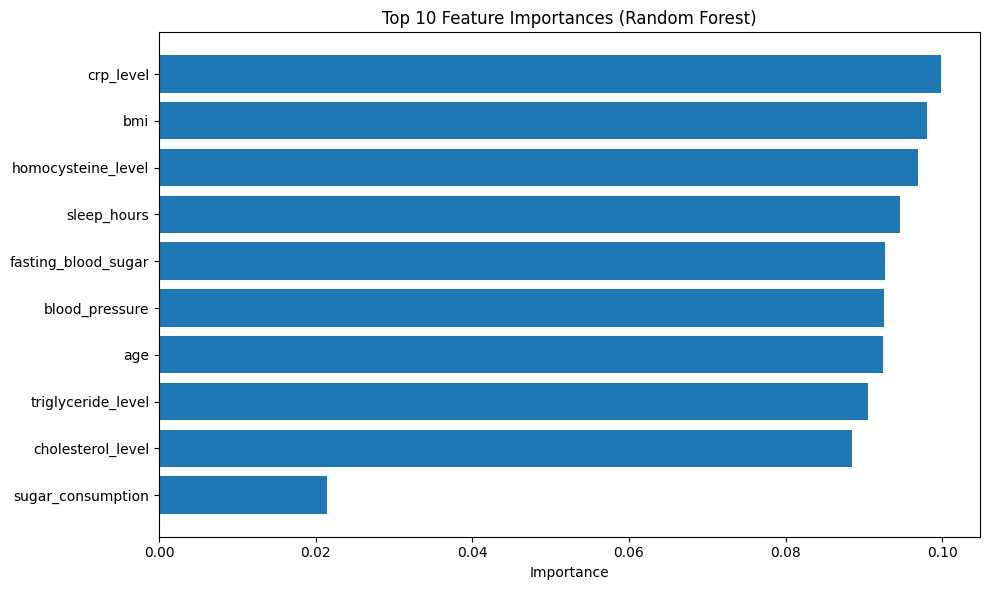

In [100]:
# Get and plot top 10 most important features
importances = best_rf.feature_importances_
features = x_train_balanced.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1600
           1       0.21      0.21      0.21       400

    accuracy                           0.68      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.68      0.68      0.68      2000



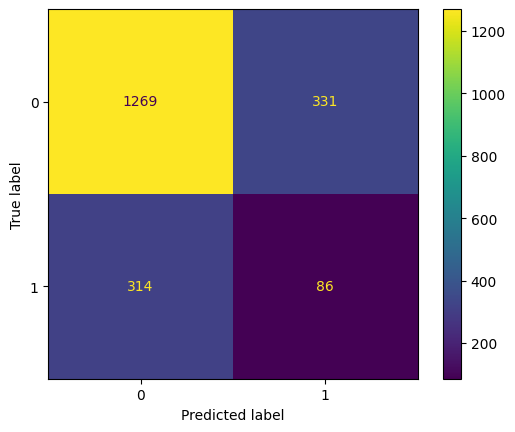

In [97]:
# Predict
y_pred = best_rf.predict(x_test)

# Evaluate
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1600
           1       0.21      0.21      0.21       400

    accuracy                           0.68      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.68      0.68      0.68      2000

=== Confusion Matrix ===


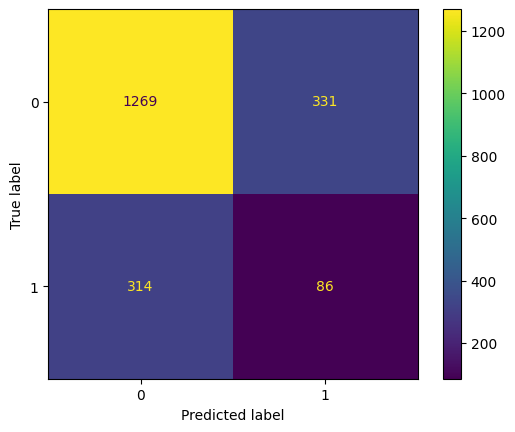

In [98]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score

# Classification report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("=== Confusion Matrix ===")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

✅ 1. Modeling Notebook
Purpose: Build, train, and tune machine learning models.

What to include:

Load preprocessed & split data (e.g., from a .pkl file)

Oversample training data

Train multiple models (e.g., Random Forest, Logistic Regression)

Use cross-validation

Hyperparameter tuning (GridSearchCV, RandomizedSearchCV)

Select the best model based on metrics

Make predictions on test data

Save the best model